In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0"#"2"

In [2]:
# import estimator class
from estimators.rnnEstimator import RnnEstimator
from estimators.kalmanEstimator import KalmanEstimator
from estimators.particleFilterEstimator import ParticleFilterEstimator

#import rewarder class
from rewarders.thresholdRewarder import ThresholdRewarder

from matplotlib import pyplot
from utils.sequences_treatment import *
from utils.agent_treatment import *
from utils.plots import *
from utils.save import *

# import functions from Keras for the RNN
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, LSTM, SimpleRNN#, Dropout, Embedding, Masking, Bidirectional
from keras.optimizers import Adam

/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/antoine/anaconda3/lib/python3.6/site-packages/tensorflow/python/frame

In [3]:
# Facultatively load a workspace
workspace_path = None#'workspaces/particle_tumor_time' # None or workspace_path (workspaces/...)

if workspace_path is not None:
    pickle_load(workspace_path, globals())
    print('Wokspace loaded.')
else:
    print('No workspace loaded.')

No workspace loaded.


In [4]:
# Set parameters
estimatorType='particle' # kalman, particle or rnn
generatorType='tumor1000' # spring, tumor or benchmark
seeAction=False
seeMeasurement=not workspace_path is None
seeEstimate=False
seeTime=True
seeSumAction=True

T=12+1

threshold=4
windowSize=T

if estimatorType=='kalman':
    cost=50 # tumor_benchmark: 0 < cost=? < ?   classic_benchmark: 0 < cost=50 < 100
elif estimatorType=='particle':
    if seeMeasurement:
        cost=500
    else:
        cost=500 # 0 < cost=? < 1000
elif estimatorType=='rnn':
    cost=500
print("cost=",cost)

cost= 500


In [5]:
# load dataset
if workspace_path is None:
    pickle_load('datasets/'+generatorType,globals())
print('done.')

generatorType='tumor'

generatorType_dataset
T_dataset
threshold_dataset
numberSamples_dataset
windowSize_dataset
objectives_trainRNN
measurements_corrupted_trainRNN
sigmas_trainRNN
inputRNN
objectives_train
measurements_train
objectives_valid
measurements_valid
objectives_test
measurements_test
load done
done.


In [6]:
if estimatorType=='rnn' and 'model' not in dir(): # if a RNN model has not been loaded
    # construct and train a Sequential RNN model with keras
    
    # use data from loaded dataset
    n_dim_meas=np.shape(measurements_corrupted_trainRNN)[2]
    n_dim_obj=np.shape(objectives_trainRNN)[2]

    model=Sequential()
    model.add(LSTM(20,input_shape=(None,n_dim_meas+1),return_sequences=True))
    model.add(LSTM(20,return_sequences=True))
    model.add(Dense(n_dim_obj,activation=None))

    model.compile(optimizer='adam',loss='mean_squared_error')
    model.summary()

    # train the RNN
    n_epochs_RNN=20
    history=model.fit(x=inputRNN,y=objectives_trainRNN,batch_size=1,epochs=n_epochs_RNN,validation_split=0.2,verbose=2)

    # plot loss
    plotRNNresults(history)
    
    idx_sample=0
    estimates_trainRNN=model.predict(inputRNN)
    plotExperiment(objectives_trainRNN, estimates_trainRNN, sigmas_trainRNN,idx_sample=idx_sample)
print('Done')

Done


In [7]:
# construct estimator
if estimatorType=='rnn':
    estimator=RnnEstimator(T,windowSize,threshold,model,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType=='particle':
    estimator=ParticleFilterEstimator(T,windowSize,threshold,generatorType,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
elif estimatorType=='kalman':
    estimator=KalmanEstimator(T,windowSize,threshold,seeAction=seeAction,seeMeasurement=seeMeasurement,seeEstimate=seeEstimate,seeTime=seeTime,seeSumAction=seeSumAction)
else:
    print('ERROR: no valid estimatorType')
    
estimator.summarize()

<class 'utils.pfilter.ParticleFilter'>
Particle filter estimator
  observationsDimensions: [(1,), (1,)]
  seeAction= False
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeSumAction= True


In [8]:
# contruct rewarder
rewarder=ThresholdRewarder(threshold=threshold, cost=cost, windowSize=windowSize)
rewarder.summarize()

Threshold rewarder
  window size: 13
  threshold: 4
  cost: 500
  number of measures in the window: 0


In [9]:
# construct agent
agent=constructAgent(estimator,rewarder,objectives_train,measurements_train,objectives_valid,measurements_valid)

agent._learning_algo.q_vals.summary()

print('Agent constructed')

Environment parameters
  inputDimensions= [(1,), (1,)]
Sequences parameters
  outOfRangeValue= -1
  n_dim_obj= 1
  n_dim_meas= 1
  numberSamples_train 1000
  numberSamples_valid 1000
Particle filter estimator
  observationsDimensions: [(1,), (1,)]
  seeAction= False
  seeMeasurement= False
  seeEstimate= False
  seeTime= True
  seeSumAction= True
Threshold rewarder
  window size: 13
  threshold: 4
  cost: 500
  number of measures in the window: 0
Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                           

In [10]:
# Train agent
n_epochs_agent=2

(numberSamples_train,T_train,_)=np.shape(objectives_train)

agent.resumeTrainingMode() # not required

start_time = time.time()
agent.run(n_epochs=n_epochs_agent, epoch_length=numberSamples_train*T_train)
elapsed_time = time.time() - start_time

cumulatedRewards_valid=agent._controllers[-1].rewards # interleavedValidEpochController is the last controller.
print('Agent Trained (in',elapsed_time,'seconds)')

Instructions for updating:
Use tf.cast instead.


/Users/antoine/Google Drive/Nathan et Antoine/optiMeasRL-main/utils/pfilter.py:372: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov_state = np.cov(self.particles, rowvar=False, aweights=self.weights)
/Users/antoine/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/antoine/Google Drive/Nathan et Antoine/optiMeasRL-main/utils/pfilter.py:363: RuntimeWarning: divide by zero encountered in log
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))
/Users/antoine/Google Drive/Nathan et Antoine/optiMeasRL-main/utils/pfilter.py:363: RuntimeWarning: invalid value encountered in multiply
  self.weight_entropy = np.sum(self.weights * np.log(self.weights))


Validation epoch running... Done.
  Testing score per episode (id: 0) is -553.6975296865579 (average over 1000 episode(s))
Training epoch 1/2.
Validation epoch running... Done.
  Testing score per episode (id: 0) is -391.2517268287604 (average over 1000 episode(s))
Training epoch 2/2.
Agent Trained (in 278.9073369503021 seconds)


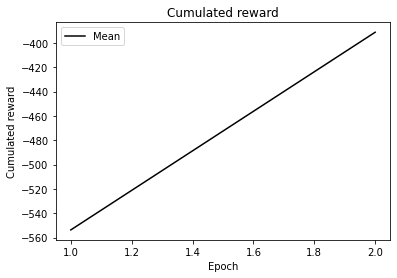

/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:308: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting/_tools.py:314: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/antoine/anaconda3/lib/python3.6/site-packages/pandas/plotting

meanReward_valid:  -391.2517268287604


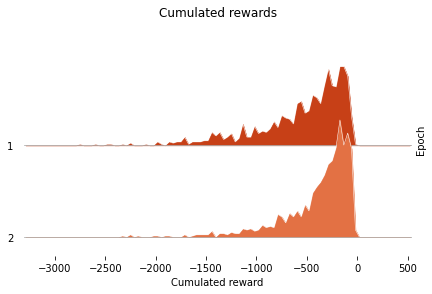

In [11]:
# plot validation
#boxplotCumulatedRewards(cumulatedRewards_valid)
plotAllCumulatedRewards(cumulatedRewards_valid)
allHistoCumulatedRewards(cumulatedRewards_valid)

meanReward_valid=np.mean(cumulatedRewards_valid[-1])
print('meanReward_valid: ',meanReward_valid)

In [12]:
(numberSamples_test,T_test,_)=np.shape(objectives_test)
# Results of the inference on test data
(sigmas_test,rewards_test,estimates_test)=agentInference(agent,objectives_test,measurements_test)
print('Test results computed')

Test results computed


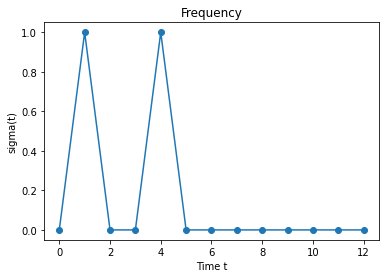

T: 13


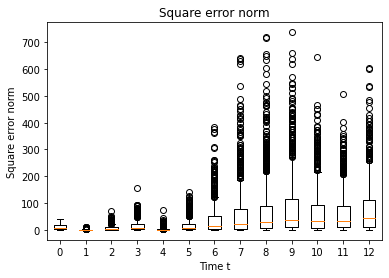

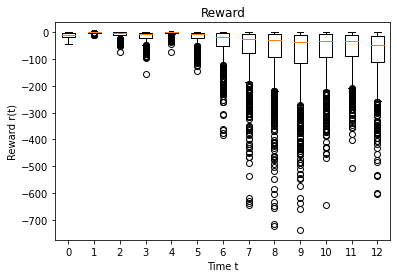

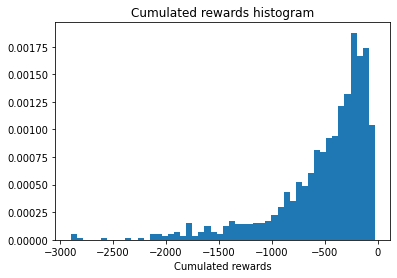

meanReward_test:  -39.304806955346386
sumSigmas_test [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2

In [13]:
# plot test
idx_sample=0
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_test)
boxplotErrors(objectives_test,estimates_test)
#plotAllErrors(objectives_test,estimates_test)
boxplotRewards(rewards_test)
#plotAllRewards(rewards_test)
histoCumulatedRewards(rewards_test)

meanReward_test=np.mean(rewards_test)
print('meanReward_test: ',meanReward_test)

sumSigmas_test=np.sum(sigmas_test,axis=1)
print('sumSigmas_test',sumSigmas_test)

In [14]:
# regular run on test data (default case without agent)
numberMeasurements=int(np.ceil(threshold/windowSize*T))

(numberSamples_test,T_test,_)=np.shape(objectives_test)

# compute regular sigma (with same dim than validation data)
sigmas_regular=regularSigma(T_test,numberMeasurements,numberSamples=numberSamples_test)

(rewards_regular, estimates_regular)=agentForcedInference(agent, sigmas_regular)
print('Done.')

/Users/antoine/Google Drive/Nathan et Antoine/optiMeasRL-main/utils/pfilter.py:372: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov_state = np.cov(self.particles, rowvar=False, aweights=self.weights)
/Users/antoine/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


Done.


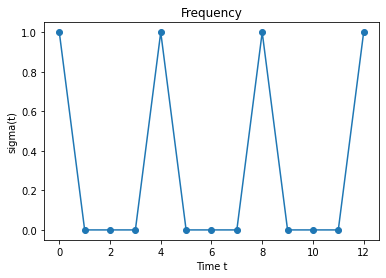

T: 13


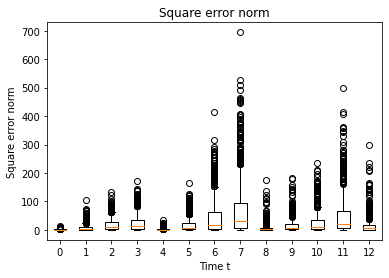

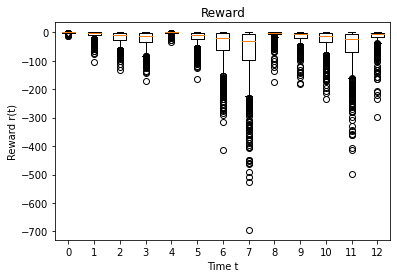

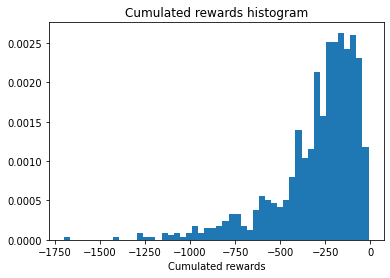

meanReward_regular:  -22.56670372462361


In [15]:
# plot test regular
idx_sample=0
#plotExperiment(objectives_test,estimates_test,sigmas_test,idx_sample=idx_sample)
freqSigmas(sigmas_regular)
boxplotErrors(objectives_test,estimates_regular)
#plotAllErrors(objectives_test,estimates_regular)
boxplotRewards(rewards_regular)
#plotAllRewards(rewards_regular)
histoCumulatedRewards(rewards_regular)
meanReward_regular=np.mean(rewards_regular)
print('meanReward_regular: ',meanReward_regular)

In [16]:
toSave=["estimatorType","generatorType","seeAction","seeMeasurement","seeEstimate","seeTime","seeSumAction","T","threshold","windowSize","cost"]
if estimatorType=='rnn':
    toSave.extend(["numberSamples_trainRNN","T_trainRNN","generatorType","objectives_trainRNN","measurements_trainRNN","n_epochs_RNN","model","history","estimates_trainRNN"])
#toSave.extend(["estimator","rewarder"])
toSave.extend(["numberSamples_train","T_train","numberSamples_valid","T_valid","objectives_train","measurements_train","objectives_valid","measurements_valid"])
toSave.extend(["n_epochs_agent","elapsed_time"])
toSave.extend(["cumulatedRewards_valid","meanReward_valid"])
toSave.extend(["numberSamples_test","T_test","objectives_test","measurements_test","sigmas_test","rewards_test","estimates_test"])
toSave.extend(["meanReward_test","sumSigmas_test"])
toSave.extend(["numberMeasurements","sigmas_regular","rewards_regular","estimates_regular","meanReward_regular"])

In [17]:
path='workspaces/'+estimatorType+'_'+generatorType
if seeMeasurement:
    path+='_self'
else:
    path+='_time'
    
pickle_save(path,toSave,globals())

estimatorType
generatorType
seeAction
seeMeasurement
seeEstimate
seeTime
seeSumAction
T
threshold
windowSize
cost
numberSamples_train
T_train
ERROR in saving
key: numberSamples_valid
'numberSamples_valid'
ERROR in saving
key: T_valid
'T_valid'
objectives_train
measurements_train
objectives_valid
measurements_valid
n_epochs_agent
elapsed_time
cumulatedRewards_valid
meanReward_valid
numberSamples_test
T_test
objectives_test
measurements_test
sigmas_test
rewards_test
estimates_test
meanReward_test
sumSigmas_test
numberMeasurements
sigmas_regular
rewards_regular
estimates_regular
meanReward_regular


In [18]:
#import os
#os.system("say Au travail faignant.")

In [21]:
numberSamples_train

1000

In [22]:
agent.__dict__

{'_controllers': [<deer.experiment.base_controllers.VerboseController at 0x1a3f1df518>,
 '_environment': <optimalIntermittency.OptimalIntermittency at 0x1a3eee7518>,
 '_learning_algo': <deer.learning_algos.q_net_keras.MyQNetwork at 0x1a3eee76a0>,
 '_replay_memory_size': 1000000,
 '_replay_start_size': 1,
 '_batch_size': 10,
 '_random_state': RandomState(MT19937) at 0x143EA2E888,
 '_exp_priority': 0,
 '_only_full_history': True,
 '_dataset': <deer.agent.DataSet at 0x1a3f1b9f60>,
 '_mode': -1,
 '_totalModeNbrEpisode': 1000,
 '_total_mode_reward': -293367.14842010615,
 '_training_loss_averages': [69.04511,
  106.684166,
  80.28763,
  14.142539,
  26.1431,
  113.03725,
  78.73592,
  42.27533,
  57.867382,
  23.317667,
  103.84877,
  57.91461,
  42.169167,
  158.90833,
  71.283,
  49.719723,
  36.993195,
  91.30495,
  85.93249,
  121.65373,
  102.328896,
  76.27045,
  48.71444,
  100.54802,
  111.71991,
  145.63483,
  44.877476,
  81.607475,
  129.68889,
  82.944336,
  75.44563,
  15.689938